# Overwatch Hero Survey (September 2019)
Firstly, thank you to the 1200 players from [/r/cow](https://reddit.com/r/competitiveoverwatch) who took the time to fill out the survey. 

**Links**
* Responses are based on this [Google Forms survey](https://forms.gle/Rgmn2CdViBApsbP6A) 
* The raw results can be found in this [Google Sheets spreadsheet](https://docs.google.com/spreadsheets/d/1Ax1unE4I2DWW3iz2Bv4c24FTUx_qxNPwrKGZ6LGNux0) 
* Original [reddit post](https://www.reddit.com/r/Competitiveoverwatch/comments/d9cmo9/5_minute_overwatch_hero_survey_fun_vs_perception/)
* The code used to generate the results can be found on [github](https://github.com/marksimpson82/overwatch_survey).

I encourage folk to check out the [github repo](https://github.com/marksimpson82/overwatch_survey) and examine/fork & modify the code.

## Caveats
1. I'm only human; the survey and analysis may contain bias or errors. 
2. The survey might tell us _what_ people think, but it doesn't really tell us _why_. 
3. It also lacks a little context: e.g. do people find hero X unfun to play against because the hero's kit is inherently flawed, or is it because of the meta?

## Goal
I'm curious about how the community perceives hero fun (playing as and against a specific hero) vs. balance. E.g.

### Are the usual suspects _really_ that OP/un-fun? 
Rationale: We see a lot of complaint threads focusing on whoever is meta, but does the community broadly hold the same opinions or is it just a loud vocal minority? Do players tend to only dislike OP heroes, or are certain heroes unpopular regardless of their power level?

### For a player maining hero X, does hero Y grind their gears?
I'm also interested in who likes/dislikes certain heroes. E.g. my hunch is `Zen` mains hate `Doomfist` the most, while `Wrecking Ball` mains hate `Sombra` or possibly `Mei`.

## Future survey improvements (TODO):
* Collect platform (PC, PC, Xbox).
* Collect whether people enjoy playing _with_ a hero on their team.
* Collect general comments at the end.
* Re-word a few questions, specifically: 
 * Make main/most-played questions more explicit (it makes more sense to ask about the last season or two rather than historical data collected over 3+ years -- Rein today is not Rein of 2016!)

In [137]:
import pandas as pd
import seaborn as sb
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# load flat csv files -- the survey results are a little clunky
hero_names_df = pd.read_csv("../data/overwatch_heroes.csv").loc[:,["Hero_name"]]
basic_info_df = pd.read_csv("../data/table_basic_info.csv")
hero_ratings_df = pd.read_csv("../data/table_hero_ratings.csv")

# join on Response_id such that we can more easily query the result set
joined_df = basic_info_df.set_index('Response_id').join(
    hero_ratings_df.set_index('Response_id'), 
    lsuffix='caller', 
    rsuffix='_other')

In [138]:
# handy constants
HERO_COUNT=len(hero_names_df)
COLUMN_PLAYING_AS="Playing_as"
COLUMN_PLAYING_VS="Playing_vs"

RATING_MIN=1
RATING_MAX=5

CHART_BAR_FIGSIZE = (6, 12)
CHART_HIST_FIGSIZE = (6, 6)

In [139]:
# helper functions for graphs
def set_graph_format_x_axis(ax):
    ax.set(xlim=(RATING_MIN, RATING_MAX))
    plt.xticks(np.arange(RATING_MIN, RATING_MAX + 1, 1))

In [140]:
def draw_fun_factor_graph(df, title):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)                
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    ax.set_title(title)
    ax.set(xlabel="Fun factor (higher is more enjoyable)", ylabel="")

## General responses

### Q: Which game modes do people play the most?

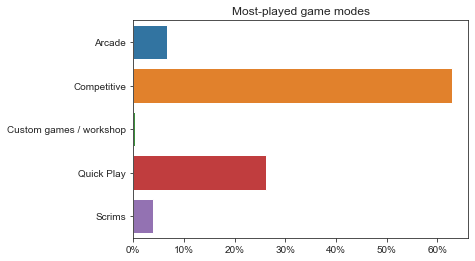

In [141]:
def draw_game_mode_chart(df):
    game_modes = (df['Game_mode']
                  .value_counts(normalize=True, sort=False)
                  .sort_index())
    
    figsize=(CHART_BAR_FIGSIZE[0], 4)
    f, ax = plt.subplots(figsize=figsize)
    ax = sb.barplot(x=game_modes.values, y=game_modes.index)    
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("Most-played game modes")    
    
draw_game_mode_chart(basic_info_df)

#### Notes
Pretty self-explanatory. It's surprising to see that roughly 40% of respondents play non-competitive game modes, though.

### Q: What rank are they?

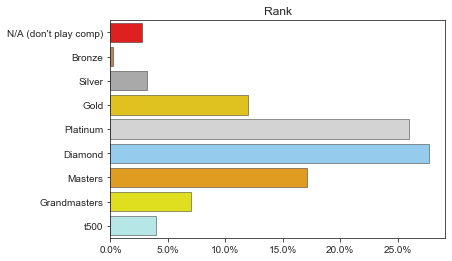

In [142]:
def draw_rank_graph(df):
    hero_time = (df['Rank']
                 .value_counts(normalize=True, sort=False))
    
    # re-order based on ascending rank so we can see the distribution
    hero_time = hero_time[[
        "N/A (don't play comp)",
        'Bronze',
        'Silver',
        'Gold',
        'Platinum',
        'Diamond',
        'Masters',
        'Grandmasters',
        't500'
    ]]
    
    palette = sb.color_palette(
        palette=[
            "red",
            "peru",
            "darkgrey",
            "gold","lightgrey",
            "lightskyblue",
            "orange",
            "yellow",
            "paleturquoise"
        ],
        n_colors=9)
     
    f, ax = plt.subplots(figsize=(CHART_BAR_FIGSIZE[0], 4))
    ax = sb.barplot(x=hero_time.values, y=hero_time.index, palette=palette, linewidth=0.5, edgecolor=".2")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    
    ax.set_title("Rank")    
    
draw_rank_graph(basic_info_df)

#### Notes
This confirms what I'd expect to see -- the members of [/r/cow](https://reddit.com/r/competitiveoverwatch) tend to be higher ranked players compared to the general population.

### Q: What roles do people play?

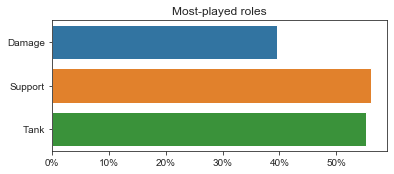

In [143]:
def draw_role_chart(df):
    roles_played_raw = (df['Most_played_roles']
                        .value_counts(normalize=True, sort=False)
                        .sort_index())
    
    TARGET_COLUMNS = ['Damage', 'Support', 'Tank']
    
    # avert your eyes -- this is messy. I'm really just looking for a simple pandas aggregation
    # method where => "if an index contains the string 'Damage', add its count to the 'Damage' sum"
    roles_played = roles_played_raw[TARGET_COLUMNS].copy()
    
    # zero these out, as we're going to re-count the originals down below
    roles_played['Damage'] = 0
    roles_played['Support'] = 0
    roles_played['Tank'] = 0    
    
    for index, value in roles_played_raw.iteritems():
        for target_col in TARGET_COLUMNS:
            if target_col in index:
                roles_played[target_col] += value    
    
    figsize=(CHART_BAR_FIGSIZE[0], 2.4)
    f, ax = plt.subplots(figsize=figsize)
    ax = sb.barplot(x=roles_played.values, y=roles_played.index)    
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("Most-played roles")    
    
draw_role_chart(basic_info_df)

#### Notes
Respondents were able to select multiple roles. The results are weighted much more towards `Tanks` & `Supports` than `Damage` (aka `DPS`), which I wasn't expecting. This colours the survey results somewhat, so bear that in mind.

### Q: Which heroes do people main?
Rationale: Mains and favourites may well differ. While certain heroes are attractive choices due to their strength or skill curve, people may play a hero in competitive to keep the peace ("don't choose Torb or I'm staying in spawn!") or for other reasons I'm unaware of.

In [168]:
def draw_hero_percent_graph(df, hero_names_df, column_name, title):        
    hero_time = (df[column_name]
                 .value_counts(normalize=True))
        
    # fill in missing data where heroes got 0 votes
    hero_time = hero_time.reindex(hero_names_df["Hero_name"].values, fill_value=0.0)
    hero_time.sort_values(inplace=True, ascending=False)
    
    assert(len(hero_time) == HERO_COUNT)
        
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)                
    ax = sb.barplot(x=hero_time.values, y=hero_time.index)    
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title(title)    
    plt.axvline(1.0/HERO_COUNT, 0.0, 1.0).set_linestyle('dashed')

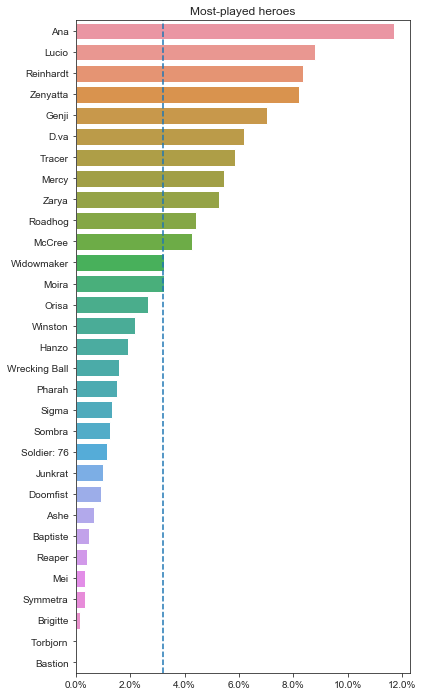

In [169]:
draw_hero_percent_graph(basic_info_df, hero_names_df, "Hero_time_1st", "Most-played heroes")

#### Notes
Caveats:

1. The wording of this question was a ambiguous -- I didn't explicitly ask for the highest overall play time in their prefered game mode _or_ the most-played hero over the last season or two. I.e. respondents would've anwswered based their interpretation of the question. My hunch is that most people took the question literally and chose their most-played hero, but I cannot be sure of that.


2. `Damage` heroes (aka `DPS`) have to compete with many more heroes in their own role, so their playtime is somewhat diluted. E.g. For much of the game's life, `Ana` had to compete with `Lucio`, `Mercy` and `Zenyatta` whereas `Junkrat` had to compete with a large cast of damage dealers.

There's a number of heroes that were released at launch or shortly thereafter that sit low in the responses. That being said, heroes like `Torbjorn`, `Symmetra` and `Bastion` have always been situational.

### Q: Which heroes are our favourites?
Rationale: Again, favourites are not equivalent to main heroes. I used to main `Tracer`, but it's a borderline throw pick.

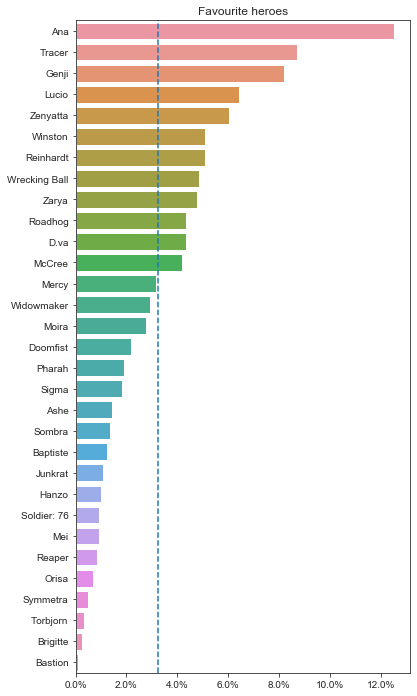

In [171]:
draw_hero_percent_graph(basic_info_df, hero_names_df, "Hero_favourite", "Favourite heroes")

#### Notes
Firstly, I can't really avoid mentioning `Brigitte`. She's sitting in the lunch hall by herself, crying. I'm not sure we can easily interpret this result; players may dislike her for any number of reasons:

* Being forced to pick `Brigitte` when she was clearly over-tuned (and this happened for *many, many months*, even pre-GOATS)
* Residual hate; `Brigitte` destroyed beloved heroes such as `Tracer`, `Genji` and `Winston` while barely breaking a sweat
* Post-rework, players view `Brigitte` as weak
* Elitism (limited mechanical requirement)
* People just haven't warmed to `Brigitte`

The second thing that sticks out is just how low `Orisa`, `Reaper` & `Mei` place. All of these heroes have been viable for months and continued to gain in strength with the introduction of `Sigma`. Given that `Orisa` is currently meta but remains unpopular, perhaps the developers might consider a re-work of sorts?

Despite a number of heroes being borderline throw picks (`Tracer` ever since `Brigitte` arrived on the scene) or a form of masochism (`Ana` vs. double shield, `Reinhardt` into `Mei`/`Reaper`/`Doomfist`), the romantics among us still love the heroes.

I'm a little surprised to see `Torbjorn`, `Symmetra`, `Bastion` & `Mei` so clearly at the bottom. I say this because the [/r/cow](https://reddit.com/r/competitiveoverwatch) subreddit used to overflow regarding one-tricks ruining the game. Either the reworks to `Torbjorn` & co largely fixed the problem, or our survey respondents are a different crowd and don't one-trick those heroes much.

I'm also confused to see `Soldier: 76` ranking so badly, as you'll see `Soldier: 76` does much better under [Q: Which heroes are fun to play as?](#Q:-Which-heroes-are-fun-play-as?) My best guess is that he's an afterthought. It's fun to play the ukelele, but why even bother when there's a 130dB death metal band in town?

Another interesting point is that `Ana` and `Wrecking Ball` are the highest placed favourite 'new' heroes by quite some margin. 

Finally, you can see certain heroes are higher in the pecking order vs. the playtime results. This is to be expected, as while we might love playing a certain hero, it's not always a viable pick.

## Q: Which heroes are fun play as?

In [176]:
def hero_fun_factor(df, response_type):
    return (df.query(f'Response_type == "{response_type}"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value', ascending=False))

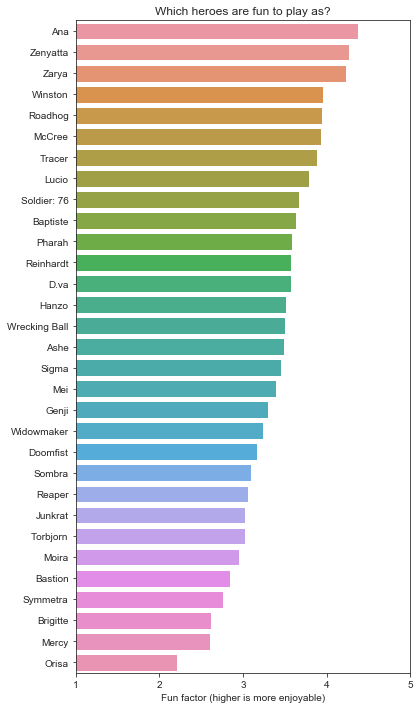

In [177]:
draw_fun_factor_graph(
    hero_fun_factor(joined_df, COLUMN_PLAYING_AS), 
    "Which heroes are fun to play as?")

#### Notes
There's a few curious results vs responses to the above question ([Q: Which heroes are our favourites?](#Q:-Which-heroes-are-our-favourites?)), but we can make an educated guess as to why.

Oh, egads! My `Mercy` is ruined! She's in the top half of respondents' favourites, but is considered distinctly un-fun to play as for the majority. My guess is that a subset of players *really* love playing `Mercy`, whereas other players are much less thrilled by the prospect. One person's flying angel is another's heal-bot.

`Orisa` continues to skulk around the bottom. In addition to respondents stating `Orisa` is un-fun to play, `Orisa` also lacks the niche appeal of `Mercy`. I guess what I'm trying to say is that `Orisa` is neither [Justin Beiber](https://www.youtube.com/watch?v=dQw4w9WgXcQ) nor [John Prine](https://www.youtube.com/watch?v=iyRzzmjK5_Q&list=PLKl69KbB34_rPmngjlvqpXJa_Sar-aXZL).

`Baptiste` does considerably better here vs. his favourites result. This suggests `Baptiste` is fairly fun to play, but has not yet replaced other heroes in our affections.

As previously mentioned, `Soldier: 76` is still hanging in there.


## Q: Which heroes are fun play against?

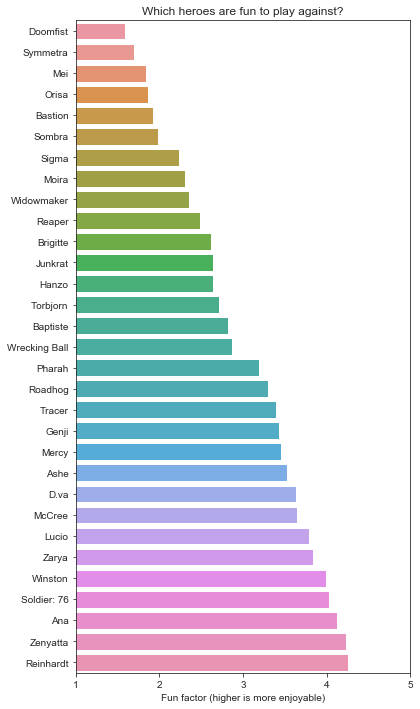

In [149]:
draw_fun_factor_graph(
    hero_fun_factor(joined_df, COLUMN_PLAYING_VS), 
    "Which heroes are fun to play against?")

## Q: Which heroes are more fun to play as than to play against?
Rationale: Optimising for the fun of one player at the expense of 6 others might tell us something about why certain heroes are strongly disliked by the playerbase. 

E.g. `Doomfist` might be satisfying to play, as it's rewarding to pull off combos that have high mechanical skill requirements. However, the players on the receiving end may feel helpless and demoralised.

On the other hand, players may enjoy fragging out on `Zen`, but this is tempered by `Zen`'s sphere-like hitbox & squishy nature.

In [150]:
def hero_fun_as_vs(df):
    """
    Q: For each hero, how fun are they to play _as_ instead of _against_?
    (e.g. a hero might be very fun to play as, but very un-fun to play against)
    """
    playing_as_df = (df.query('Response_type == "Playing_as"')
     .groupby('Hero')
     .mean())
    
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())   
   
    fun_difference_df = (playing_as_df.join(
        playing_vs_df,    
        lsuffix='_fun_as', 
        rsuffix='_fun_vs'))      
    
    fun_difference_df["Value_fun_difference"] = (
        fun_difference_df["Value_fun_as"] - 
        fun_difference_df["Value_fun_vs"])

    fun_difference_df.sort_values(by="Value_fun_difference", inplace=True)
                
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    
    ax = sb.barplot(x="Value_fun_difference", y=fun_difference_df.index, data=fun_difference_df)    
    ax.set(xlabel="Playing as/vs fun difference", ylabel="")
        
    plt.axvline(0.0, 0.0, 1.0).set_linestyle('dashed')    

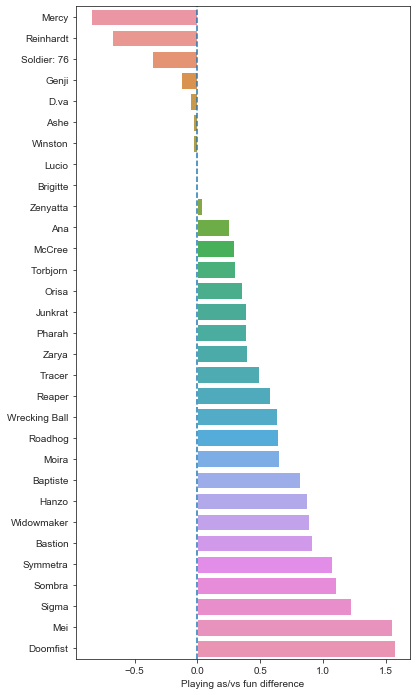

In [151]:
hero_fun_as_vs(joined_df)

## Q: Where do heroes fall on the balance scale? 
Rationale: Gives us a feel for heroes that are considered weak/balanced/over-tuned (aka OP)

In [152]:
def hero_balance(df):
    return (joined_df.query('Response_type == "Balance"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value'))

In [153]:
def draw_hero_balance_graph(df):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    
    # plot ideal balance line
    balance_line_x = CHART_BAR_FIGSIZE[0] * 0.5
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')
    
    ax.set_title("Which heroes are perceived to be balanced?")
    ax.set(xlabel="Balance rating -- 3 is considered to be well-balanced", ylabel="")

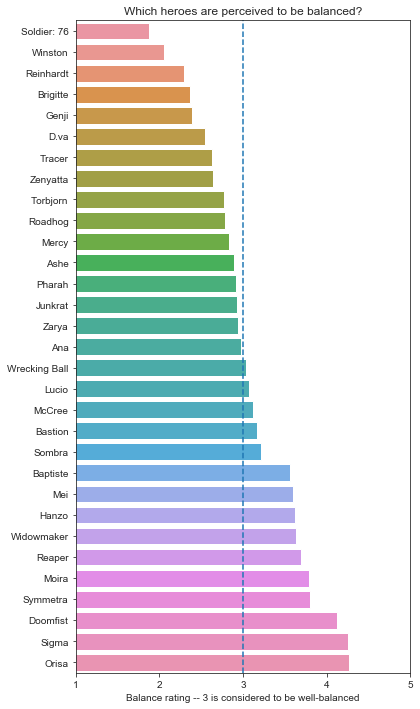

In [154]:
draw_hero_balance_graph(hero_balance(joined_df))

### Let's break down balance by hero & see the range of votes
Rationale: More of a curiosity, but are heroes viewed largely uniformly (bell curve distribution) or are some heroes more divisive, with a more equal distribution of votes for weak/balanced/OP?

In [155]:
@interact
def hero_balance_histograms(column=list(sorted(hero_names_df['Hero_name']))):
    hero_playing_vs_df = (joined_df.query('Response_type == "Playing_vs"')
                          .groupby('Hero'))['Value']

    # todo: figure out how to make the axis labels marry up with the result buckets a bit better.
    f, ax = plt.subplots(figsize=CHART_HIST_FIGSIZE)
    sb.set_style("ticks")
    dp = sb.distplot(hero_playing_vs_df.get_group(column), bins=5, kde=False)
    dp.set(xlabel=f'Playing vs {column}', ylabel='Counts')    
    plt.show()        

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…

## Q: Which heroes are fun to play against relative to their perceived balance?
Rationale: I'd expect to see an inversely proportional relationship between hero strength and fun (i.e. the more OP a hero is, the less fun it is to play against them). 

Are there any weak heroes that significantly buck this trend? If so, it suggests the hero design may have inherent problems.

In [156]:
def hero_fun_vs_balance(df):
    """
    Q: which heroes are unpopular relative to their perceived balance level? 
    (i.e. people dislike playing against them even if they're not considered OP)
    """
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())
    
    balance_df = (df.query('Response_type == "Balance"')
     .groupby('Hero')
     .mean())
    
    # our fun and balance ranges go from [1, 5], so let's move them into the range
    # 0 to 4, then transform them into the range [-1, +1]. E.g. a 1 => -1, 5 => 1
    # this will make it easy to see if they 'cancel out' or not
    playing_vs_df = (playing_vs_df - 3.0) / 2.0
    balance_df = (balance_df - 3.0) / 2.0
    
    fun_balance_df = (playing_vs_df.join(
        balance_df,    
        lsuffix='_fun', 
        rsuffix='_balance')
      .query('Value_balance.notnull()')) # filter out the invalid joined data; should do this first though
    
    # this is a little arbitrary, but gives us a decent idea of 'fun/unfun' vs balance.    
    # we have a fun rating range [-1, 1] and a strength rating range [-1, 1]. 
    # 
    # we'd expect to see something of an inverse relationship between fun and balance,
    # so we're going to add them together and plot the whole lot. Adding the two values
    # should roughly cancel out, and anything that significantly departs from 0 should 
    # give us a feel for outliers in a fun/power relationship.
    # 
    # Examples:
    #
    # 1. hero that is viewed as well-balanced and also OK to play against:
    #   fun: 0.1, strength: -0.05 (i.e. these values are both close to 0)
    #   result: 0.1 + (-0.05) = 0.05
    #   interpretation: fun and balance are in check
    #
    # 2. hero that is un-fun and also also weak:
    #   fun: -0.5, strength: -0.3 (i.e. these values are both negative)
    #   result: -0.5 + (-0.3) = -0.8
    #   interpretation: the hero design has inherently un-fun elements even though weak.
    #
    # 3. hero that is fun and also slightly OP
    #   fun: 0.7, strength: 0.3
    #   result: 0.7 + 0.3 = 1.0
    #   interpretation: the hero design is inherently so much fun that we forgive the OPness
    fun_balance_df["Value_relative_balance"] = (
        fun_balance_df["Value_balance"] + 
        fun_balance_df["Value_fun"])

    fun_balance_df.sort_values(by="Value_relative_balance", inplace=True)
    return fun_balance_df    
    
def draw_hero_fun_vs_balance_graph(df):
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    
    ax = sb.barplot(x="Value_relative_balance", y=df.index, data=df)    
    ax.set(xlabel="Playing against hero: fun relative to balance", ylabel="")
    
    # plot balance vs. fun baseline. Any hero to the <--- left of this line is considered
    # un-fun relative to their balance level. 
    balance_line_x = 0.0
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')


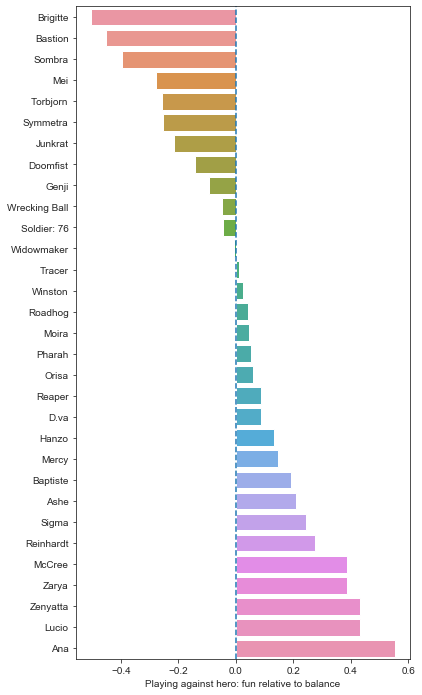

In [157]:
draw_hero_fun_vs_balance_graph(
    hero_fun_vs_balance(joined_df))

## Q: When maining a specific hero, which heroes are fun/un-fun to play against?
Rationale: Do the hero fun/un-fun rankings change significantly by which hero the respondents main, or are some heroes just universally unpopular to play against?

E.g. my hunch is Zen mains hate Doomfist the most, while Wrecking Ball mains hate Sombra or possibly Mei.

In [158]:
def hero_fun_vs_balance_by_main(df, hero_names):    
    @interact
    def hero_fun_vs_balance_by_main_interact(column=hero_names):        
        hero_name = column
        hero_playing_as_df = (df.query(
            f'Hero_favourite == "{hero_name}" & Response_type == "Playing_vs"'))
                
        response_count_for_main = int(len(hero_playing_as_df) / len(hero_names))
        
        if response_count_for_main < 1:            
            print(f"There were {response_count_for_main} responses from {hero_name} mains. Nothing to display.")
            return        

        # for hero x, we have results for playing against all heroes. 
        # spin through every result in this set and query for the top 3 most-hated
        least_fun_group = (hero_playing_as_df
                           .query(f'Response_type == "Playing_vs"')
                           .groupby("Hero", as_index=False))

        least_fun_mean = (least_fun_group.mean()
                          .sort_values(by='Value'))
        
        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
        ax = sb.barplot(x="Value", y="Hero", data=least_fun_mean)
        #set_graph_format_x_axis(ax)
        ax.set_title(f"Respondents' main: {hero_name}. (N: {response_count_for_main})")
        ax.set(xlabel="Fun factor (higher is more enjoyable)", ylabel="Playing against hero")
        set_graph_format_x_axis(ax)
        
hero_fun_vs_balance_by_main(joined_df, list(sorted(hero_names_df['Hero_name'])))

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…